# RET Wild Type Dataset and Benchmark

- [Data curation](#curation)

**RET (Rearranged during Transfection)** is a proto-oncogene that codes for a receptor tyrosine kinase. This means it produces a protein that plays a role in signaling pathways within cells, particularly related to cell growth and differentiation. When activated, RET helps regulate cell survival, proliferation, and differentiation. Mutations or alterations in the RET gene can lead to uncontrolled cell growth and potentially the development of cancer.

- **RET wild type**: In some cases, targeting both mutant and wild-type RET together can be more effective than targeting only one form as Combination Therapies.
In certain cancer types, such as some subtypes of non-small cell lung cancer (NSCLC), the RET signaling pathway can interact with other oncogenic pathways, such as the EGFR (epidermal growth factor receptor) pathway. Targeting both pathways simultaneously might offer a synergistic effect and improve treatment outcomes.

**Published EGFR datasets**: 
- **PKIS2**: A second chemogenomics set of kinase inhibitors from GSK, Takeda, and Pfizer was assembled as PKIS2. This set contained 645 inhibitors and included many additional chemotypes that were not represented in the original set. [ref]

**Description of readout:**
- **Readouts**: `RET`
- **Bioassay readout**: Percentage of inhnibition.
- **Optimization objective**: Higher the more potent.

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
from polaris import curation
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pathlib
os.chdir(pathlib.Path("__file__").absolute().parents[3])
from utils import *

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

In [2]:
# load data
data = pd.read_parquet(
    "gs://polaris-public/Data/kinases/pkis2_curated_&_splits_2023-08-23.parquet"
)

In [3]:
# Define data column names
data_cols = ['RET']
mol_col = "smiles"
data = data[[mol_col] + data_cols].dropna(subset=data_cols, ignore_index=True)

In [4]:
data.describe()[data_cols]

,RET
count,640.000000
mean,25.133125
std,31.802146
min,0.000000
25%,0.000000
50%,12.000000
75%,32.250000
max,100.000000


## Check the distribution of the RET WT % inhibition

In [5]:
data[data_cols].groupby(pd.cut(data["RET"], [0,70,75, 80, 90, 100])).count()

,RET
RET,
"(0, 70]",382
"(70, 75]",5
"(75, 80]",8
"(80, 90]",13
"(90, 100]",66


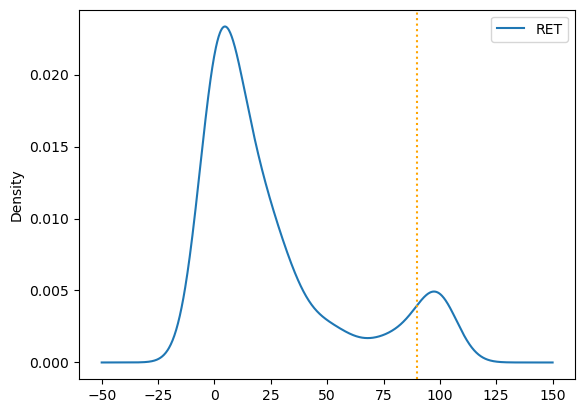

In [6]:
fig = data[data_cols].plot.kde()
plt.axvline(x=90, linestyle="dotted", color="orange")

### Perform data curation with `polaris.curation` module

In [7]:
# Define the threshold for classification conversion 
# we use the recommanded threshold 90% from the paper
th = 90
class_thresholds = {col: {"thresholds": [th]} for col in data_cols}

In [8]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=True,
    class_thresholds=class_thresholds
)
df_full = curator_with_stereo()

In [9]:
for col in data_cols:
    display(df_full.query(f'`OUTLIER_{col}` == True')[data_cols])

,RET


No warnings of potential outliers were raised.

### Check the compounds with undisered characters

In [10]:
from utils import basic_filter

In [11]:
processed_df = basic_filter(data = df_full, mol_col='smiles')

Filter by rules:   0%|          | 0/640 [00:00<?, ?it/s]

In [12]:
assert processed_df[processed_df.HasUndesiredEle].shape[0] == 0

There is no compounds which contains undiserable elements.

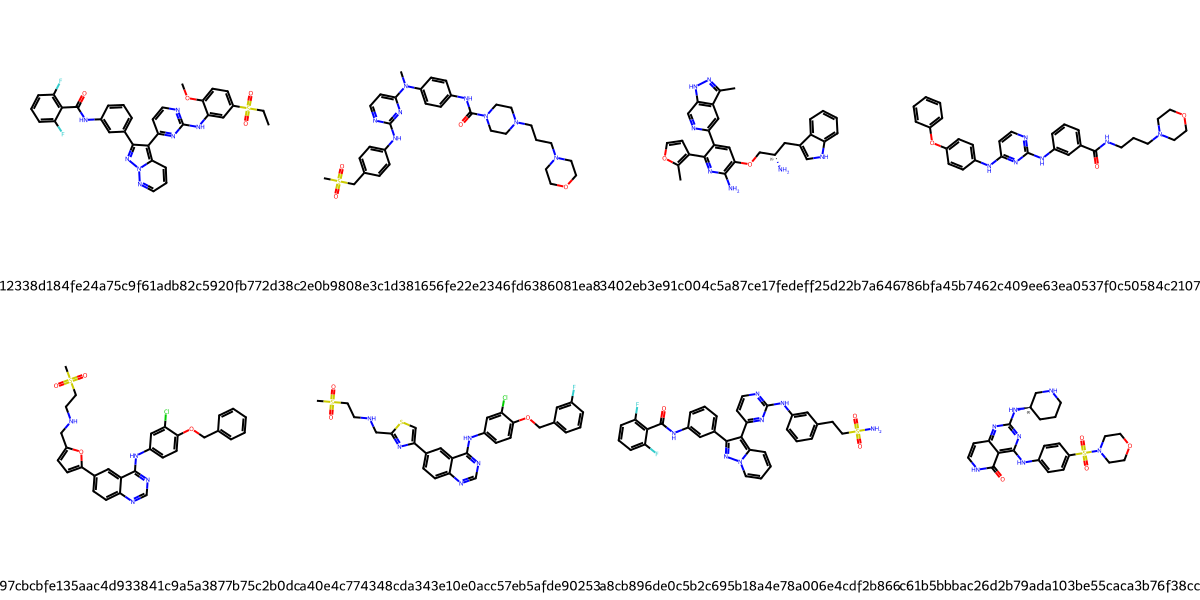

In [13]:
# visualize molecules which don't pass any of the nibr filters.
id_col = "molhash_id"
to_plot = processed_df[~processed_df.pass_any]
legends=to_plot[id_col].astype(str).tolist()
dm.to_image(to_plot['mol'].tolist(), 
            legends=legends, legendFraction=0.1,
            use_svg=True, n_cols=4)

NIBR filters are intended for molecule prioritization in the context of screening. \
Here we used to flag the molecules which are potentially undesired for the benchmark.\
From the above suggested molecules, there is no compound which contains striking unwanted substructure or extremely large groups. 

## Chemical space

In [14]:
mols = df_full.smiles.apply(dm.to_mol)
features = [dm.to_fp(mol) for mol in mols]

In [15]:
embedding = umap.UMAP().fit_transform(features)
df_full["UMAP_0"], df_full["UMAP_1"] = embedding[:, 0], embedding[:, 1]

Text(0.5, 1.0, 'UMAP Embedding of compounds for RET')

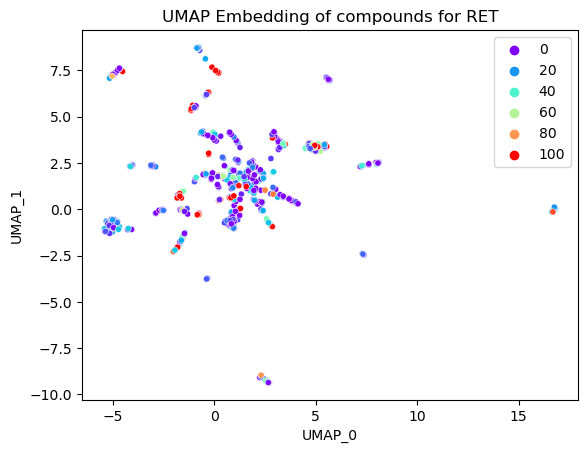

In [16]:
method = "UMAP"

fig = sns.scatterplot(
    data=df_full,
    x="UMAP_0",
    y="UMAP_1",
    palette="rainbow",
    hue=df_full[data_cols[0]].values,
    s=20,
)
fig.set_title(f"{method} Embedding of compounds for {col}")

With the above representation, overall, the most potent compounds are spread in the chemical space. One of the clusters contains more potent molecules.
The goal are to 1) optimize the bioactivity % inhibition. 2) discovery of potential hits in new chemical space. Therefore, a scaffold based split method is more relevant in this context. 

In [19]:
from polaris.curation._chemistry_curator import UNIQUE_ID
df_full.rename(columns={UNIQUE_ID: "UNIQUE_ID"}, inplace=True)
df_full.drop(columns=["UMAP_0", "UMAP_1"]).to_parquet( 
    "gs://polaris-public/Data/kinases/RET_WT_curated.parquet", index=False)